In [5]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import theano.tensor as tt



### Generate sample data

We generate book rates for 52 weeks of the year, where each rate represents the % of orders booked for a given week in each time period. So, we get 52x52 values, each representing the % of final bookings for week W booked as of time period T.

In [4]:
n_weeks = 52
n_time_periods = 52

In [112]:
event_weeks = np.linspace(1, n_weeks, n_time_periods, dtype=int)
event_weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [113]:
time_periods = np.linspace(n_time_periods, 0, n_time_periods+1, dtype=int)

In [114]:
reservation_weeks = np.abs(time_periods-n_time_periods)

In [115]:
booking_rate = reservation_weeks/n_time_periods
booking_rate

array([0.        , 0.01923077, 0.03846154, 0.05769231, 0.07692308,
       0.09615385, 0.11538462, 0.13461538, 0.15384615, 0.17307692,
       0.19230769, 0.21153846, 0.23076923, 0.25      , 0.26923077,
       0.28846154, 0.30769231, 0.32692308, 0.34615385, 0.36538462,
       0.38461538, 0.40384615, 0.42307692, 0.44230769, 0.46153846,
       0.48076923, 0.5       , 0.51923077, 0.53846154, 0.55769231,
       0.57692308, 0.59615385, 0.61538462, 0.63461538, 0.65384615,
       0.67307692, 0.69230769, 0.71153846, 0.73076923, 0.75      ,
       0.76923077, 0.78846154, 0.80769231, 0.82692308, 0.84615385,
       0.86538462, 0.88461538, 0.90384615, 0.92307692, 0.94230769,
       0.96153846, 0.98076923, 1.        ])

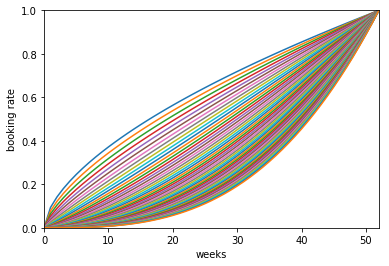

In [116]:
fig, ax = plt.subplots()
rates = np.linspace(.6, 3, n_weeks)
for r in rates:
    ax.plot(weeks, np.power(reservation_weeks/n_time_periods, r), label=f'r={r}')
ax.set(xlim=[0,n_weeks], ylim=[0,1], xlabel='weeks', ylabel='booking rate')
plt.show()

In [117]:
bookings_rates = [np.power(reservation_weeks/n_time_periods, r) for r in rates]

In [176]:
col_time_periods = [f'T{t}' for t in time_periods]
df_bookings_rates = pd.DataFrame(bookings_rates, columns=col_time_periods)

In [177]:
df_bookings_rates.loc[:, 'event_week'] = [f'W{w}' for w in event_weeks]

In [178]:
df_bookings_rates = df_bookings_rates[['event_week'] + col_time_periods]

In [179]:
df_bookings_rates.head()

,event_week,T52,T51,T50,T49,T48,T47,T46,T45,T44,...,T9,T8,T7,T6,T5,T4,T3,T2,T1,T0
0,W1,0.0,0.093411,0.141585,0.180580,0.214602,0.245347,0.273709,0.300232,0.325276,...,0.892235,0.904627,0.916907,0.929079,0.941145,0.953109,0.964974,0.976742,0.988417,1.0
1,W2,0.0,0.077561,0.121459,0.157896,0.190201,0.219745,0.247260,0.273195,0.297850,...,0.884291,0.897543,0.910690,0.923734,0.936679,0.949526,0.962279,0.974941,0.987514,1.0
2,W3,0.0,0.064401,0.104194,0.138061,0.168575,0.196815,0.223368,0.248593,0.272736,...,0.876418,0.890515,0.904515,0.918420,0.932233,0.945956,0.959592,0.973143,0.986612,1.0
3,W4,0.0,0.053474,0.089383,0.120717,0.149407,0.176278,0.201784,0.226207,0.249740,...,0.868615,0.883542,0.898382,0.913136,0.927808,0.942400,0.956913,0.971349,0.985711,1.0
4,W5,0.0,0.044400,0.076678,0.105553,0.132419,0.157884,0.182285,0.205836,0.228683,...,0.860881,0.876623,0.892290,0.907883,0.923405,0.938857,0.954240,0.969558,0.984811,1.0


In [136]:
total_reservations = np.random.randint(3000, 10000, n_weeks)

In [158]:
total_reservations

array([3703, 7449, 3991, 3615, 8982, 3169, 7989, 5850, 7801, 6033, 4173,
       9570, 9247, 6586, 6678, 5341, 4714, 8885, 8039, 5992, 4384, 8431,
       6352, 9585, 4657, 9838, 8913, 4241, 3432, 4470, 7844, 4583, 5961,
       9811, 6589, 6118, 5727, 9816, 4191, 7955, 4612, 4841, 8239, 9263,
       3835, 5425, 9213, 8016, 4964, 6903, 5154, 3453])

In [160]:
event_weeks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [174]:
cumulative_reservations = [np.round(bookings_rates[i-1] * total_reservations[i-1], 0).astype(int) for i in event_weeks]

In [180]:
col_time_periods = [f'T{t}' for t in time_periods]
df_cumulative_reservations = pd.DataFrame(cumulative_reservations, columns=col_time_periods)
df_cumulative_reservations.loc[:, 'event_week'] = [f'W{w}' for w in event_weeks]
df_cumulative_reservations = df_cumulative_reservations[['event_week'] + col_time_periods]
df_cumulative_reservations.head()

,event_week,T52,T51,T50,T49,T48,T47,T46,T45,T44,...,T9,T8,T7,T6,T5,T4,T3,T2,T1,T0
0,W1,0,346,524,669,795,909,1014,1112,1204,...,3304,3350,3395,3440,3485,3529,3573,3617,3660,3703
1,W2,0,578,905,1176,1417,1637,1842,2035,2219,...,6587,6686,6784,6881,6977,7073,7168,7262,7356,7449
2,W3,0,257,416,551,673,785,891,992,1088,...,3498,3554,3610,3665,3721,3775,3830,3884,3938,3991
3,W4,0,193,323,436,540,637,729,818,903,...,3140,3194,3248,3301,3354,3407,3459,3511,3563,3615
4,W5,0,399,689,948,1189,1418,1637,1849,2054,...,7732,7874,8015,8155,8294,8433,8571,8709,8846,8982


## Model